In [2]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql.functions import datediff, to_date, lit, to_timestamp, col
from pyspark.sql.types import DateType

In [3]:
# create the session
spark = SparkSession.builder.getOrCreate()

# create the context
sc = spark.sparkContext

In [4]:
userProfile = spark.read.csv("data/users/public_users.csv", header = True)
egoTimeline1 = spark.read.csv("data/users/public_users_timelines_1.csv", header = True)
egoTimeline2 = spark.read.csv("data/users/public_users_timelines_2.csv", header = True)
egoTimeline = egoTimeline1.union(egoTimeline2)

userProfile = userProfile.filter("followers_count >= 1" or "following_count >= 1")

temp = userProfile.withColumn("record_date",userProfile['created_at'].cast(DateType()))
userProfileWithTime = temp.withColumn("days", datediff(to_date(lit("2020-12-12")),'record_date'))

userProfileWithTime = userProfileWithTime.withColumn("dailyTweetsAverage",lit(userProfileWithTime.tweet_count/userProfileWithTime.days))

In [5]:
userProfileWithTimePandas = userProfileWithTime.toPandas()
userProfileWithTimePandas = userProfileWithTimePandas[userProfileWithTimePandas["followers_count"].str.isdigit() == True]
userProfileWithTimePandas["followers_count"] = userProfileWithTimePandas["followers_count"].astype(int)

userProfileWithTimePandas = userProfileWithTimePandas[userProfileWithTimePandas["following_count"].str.isdigit() == True]
userProfileWithTimePandas["following_count"] = userProfileWithTimePandas["following_count"].astype(int)

userProfileWithTimePandas = userProfileWithTimePandas[userProfileWithTimePandas["tweet_count"].str.isdigit() == True]

In [6]:
egoTimeline.groupby("user_id").count().orderBy("count", ascending = False).show()
#egoTimeline.filter(egoTimeline["Value"] != False)
#egoTimeline
#egoTimeline.groupby("user_id").count().show()
#egoFiltered = egoTimeline.filter(egoTimeline["user_id"]== userProfileWithTime["id"])

+----------+-----+
|   user_id|count|
+----------+-----+
|         .|13900|
|2396176568| 3800|
|1330759578| 3800|
|  36097879| 3800|
|1212342841| 3800|
| 136886942| 3799|
| 160475411| 3797|
|1879468412| 3789|
|   6715202| 3780|
|2730768019| 3760|
| 204040664| 3758|
|1240234080| 3747|
| 201404747| 3737|
| 252744530| 3733|
| 386771443| 3671|
| 189787944| 3648|
|1256677638| 3640|
| 256500614| 3627|
| 318721655| 3625|
|2601717884| 3622|
+----------+-----+
only showing top 20 rows



In [7]:
egoTimeline1=pd.read_csv("data/users/public_users_timelines_1.csv",lineterminator='\n')

In [8]:
egoTimeline2=pd.read_csv("data/users/public_users_timelines_2.csv",lineterminator='\n')

In [9]:
egoTimeline2.shape

(1589061, 22)

In [10]:
egoTimeline_pd_all=pd.concat([egoTimeline1,egoTimeline2],axis=0)

In [11]:
egoTimeline_pd_all.user_id.value_counts()

1212342841    3800
36097879      3800
2396176568    3800
1330759578    3800
136886942     3799
              ... 
2566081733       1
2876982061       1
1366213777       1
2472505256       1
173128092        1
Name: user_id, Length: 13635, dtype: int64

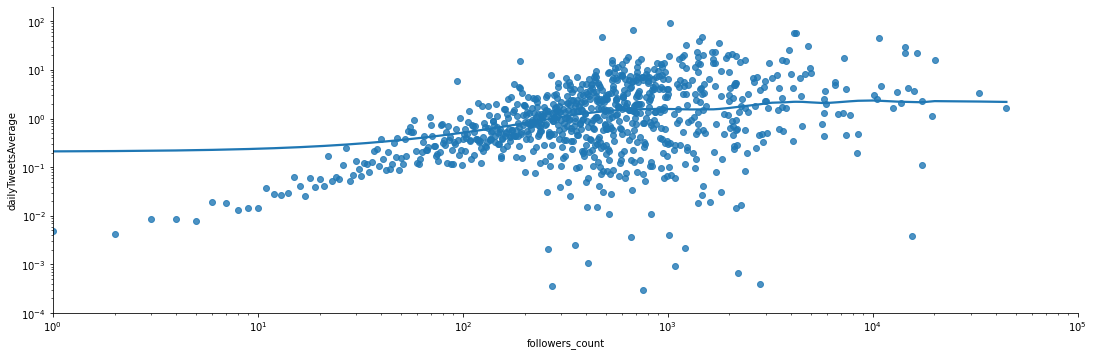

In [12]:
t = userProfileWithTimePandas.groupby("followers_count").mean().reset_index()
splot = sns.lmplot(x="followers_count", y="dailyTweetsAverage", data=t,
           lowess=True,
           aspect=3)

splot.set(xscale = "log")
splot.set(yscale = "log")
# control x and y limits
plt.ylim(0.0001, 200)
plt.xlim(1, 100000)

 
plt.show()


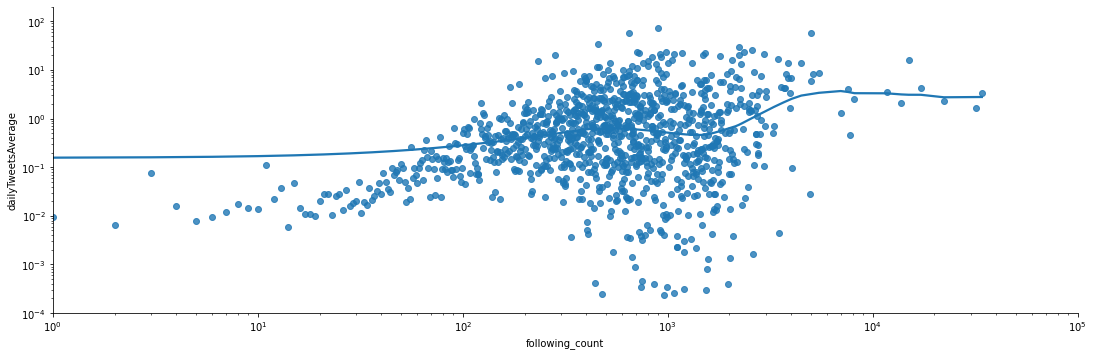

In [13]:
d = userProfileWithTimePandas.groupby("following_count").mean().reset_index()

splot = sns.lmplot(x="following_count", y="dailyTweetsAverage", data=d,
           lowess=True,
           aspect=3)

splot.set(xscale = "log")
splot.set(yscale = "log")
# control x and y limits
plt.ylim(0.0001, 200)
plt.xlim(1, 100000)

 
plt.show()


In [14]:
followingCor = np.log(userProfileWithTimePandas["following_count"])
followersCor = np.log(userProfileWithTimePandas["followers_count"])
dailyTweetCor= np.log(userProfileWithTimePandas["dailyTweetsAverage"])
tweetCountCor = np.log(userProfileWithTimePandas["tweet_count"].astype(int))


data = {'DailyTweetsAverage':dailyTweetCor , 'FollowersCount': followersCor, 'Following_count':followingCor }
cor1 = pd.DataFrame(data = data)
print(cor1.corr( method= 'pearson'))

data2 = {'TweetsCount':tweetCountCor , 'FollowersCount': followersCor, 'Following_count':followingCor }
cor2 = pd.DataFrame(data = data2)
print(cor2.corr( method= 'pearson'))

                    DailyTweetsAverage  FollowersCount  Following_count
DailyTweetsAverage            1.000000        0.744386         0.613695
FollowersCount                0.744386        1.000000         0.723578
Following_count               0.613695        0.723578         1.000000
                 TweetsCount  FollowersCount  Following_count
TweetsCount         1.000000        0.747128         0.610013
FollowersCount      0.747128        1.000000         0.723578
Following_count     0.610013        0.723578         1.000000


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
# dailyTweetsAverage (number of friends)

In [92]:
egoTimeline_pd_all.head(15)

,user_id,user,id,created_at,text,in_reply_to_status_id,in_reply_to_user_id,source,truncated,coordinates,place,is_quote_status,quoted_status_id,quoted_status,quote_count,retweeted_status,retweet_count,favorite_count,entities,extended_entities,possibly_sensitive,lang
0,129007523,"{'id': 129007523, 'id_str': '129007523', 'name': 'Beatriz', 'screen_name': 'biabiz', 'location': '', 'description': '', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 15, 'friends_count': 3, 'listed_count': 0, 'created_at': 'Fri Apr 02 22:25:11 +0000 2010', 'favourites_count': 0, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 1, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': 'C0DEED', 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_tile': False, 'profile_image_url': 'http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png', 'profile_image_url_https': 'https://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png', 'profile_link_color': '1DA1F2', 'profile_sidebar_border_color': 'C0DEED', 'profile_sidebar_fill_color': 'DDEEF6', 'profile_text_color': '333333', 'profile_use_background_image': True, 'has_extended_profile': False, 'default_profile': True, 'default_profile_image': True, 'following': None, 'follow_request_sent': None, 'notifications': None, 'translator_type': 'none'}",11504272778,Fri Apr 02 22:48:45 +0000 2010,...,NaN,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",False,NaN,NaN,False,NaN,NaN,NaN,NaN,0,0,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}",NaN,NaN,und
1,32670411,"{'id': 32670411, 'id_str': '32670411', 'name': 'grace freeman', 'screen_name': 'girl51', 'location': '', 'description': '', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 3, 'friends_count': 20, 'listed_count': 0, 'created_at': 'Fri Apr 17 23:54:26 +0000 2009', 'favourites_count': 0, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 1, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': 'C0DEED', 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_tile': False, 'profile_image_url': 'http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png', 'profile_image_url_https': 'https://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png', 'profile_link_color': '1DA1F2', 'profile_sidebar_border_color': 'C0DEED', 'profile_sidebar_fill_color': 'DDEEF6', 'profile_text_color': '333333', 'profile_use_background_image': True, 'has_extended_profile': False, 'default_profile': True, 'default_profile_image': True, 'following': None, 'follow_request_sent': None, 'notifications': None, 'translator_type': 'none'}",1546860218,Fri Apr 17 23:58:43 +0000 2009,makeing dinner for the family,NaN,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",False,NaN,NaN,False,NaN,NaN,NaN,NaN,0,0,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}",NaN,NaN,en
2,555533734,"{'id': 555533734, 'id_str': '555533734', 'name': 'Feral Watches', 'screen_name': 'FeralWatches', 'location': 'Boise, Idaho', 'description': 'Watches For The Wild', 'url': 'http://t.co/81oE5BB7qD', 'entities': {'url': {'urls': [{'url': 'http://t.co/81oE5BB7qD', 'expanded_url': 'http://www.feralwatches.com', 'display_url': 'feralwatches.com', 'indices': [0, 22]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 310, 'friends_count

In [109]:
#get ids that was mentioned by user_id in timeline
import ast
def get_id_of_user(egoTimeline_pd_all):
    a=egoTimeline_pd_all.entities.apply(ast.literal_eval)
    b=a.apply(lambda x: x['user_mentions'])
    idd=b.apply(lambda x: -1 if not x else x[0]['id'])
    return idd

In [110]:
#get id that was mentioned by user_id in timeline
mentioned_id=get_id_of_user(egoTimeline_pd_all)
user_id_and_mentioned_id=pd.concat([egoTimeline_pd_all.user_id,mentioned_id],axis=1)

In [111]:
#drop cases when user mentione himself
user_id_and_mentioned_id=user_id_and_mentioned_id[user_id_and_mentioned_id.user_id!=user_id_and_mentioned_id.entities]

In [112]:
user_id_and_mentioned_id.head(20)

,user_id,entities
0,129007523,-1
1,32670411,-1
2,555533734,-1
3,555533734,-1
4,555533734,-1
5,555533734,-1
7,555533734,-1
8,555533734,-1
9,555533734,-1
10,555533734,-1


In [113]:
#filter on users that didn't mention anyone
user_id_and_mentioned_id=user_id_and_mentioned_id[user_id_and_mentioned_id.entities!=-1]
user_id_and_count_mentioned_id=user_id_and_mentioned_id.groupby(['user_id','entities']).size().reset_index()

In [114]:
#number_of_mentioned_id  - how much time that person was mentioned in ego's timeline
user_id_and_count_mentioned_id=user_id_and_count_mentioned_id.rename({'entities':'mentioned_id','0':'number_of_mentioned_id'},axis=1)

In [115]:
#rename columns
user_id_and_count_mentioned_id=user_id_and_count_mentioned_id.rename({0:'number_of_mentioned_id'},axis=1)

In [116]:
#user_id - ego's id, mentioned_id - user's id that was mentioned by ego, number_of_mentioned_id - how much time that person was mentioned in ego's timeline
user_id_and_count_mentioned_id.head()

,user_id,mentioned_id,number_of_mentioned_id
0,6368722,76133,1
1,6368722,202003,2
2,6368722,662323,1
3,6368722,678953,1
4,6368722,768632,1


In [117]:
#Friend is defined as a user who has been mentioned at least twice in an ego’s timeline.
user_id_and_count_mentioned_id=user_id_and_count_mentioned_id[user_id_and_count_mentioned_id.number_of_mentioned_id>=2]

In [118]:
#change type to oin
user_id_and_count_mentioned_id.user_id=user_id_and_count_mentioned_id.user_id.astype(str)

In [119]:
#join with dailyTweetsAverage
user_id_and_count_mentioned_id=user_id_and_count_mentioned_id.merge(userProfileWithTimePandas[['id','dailyTweetsAverage']],
                                                                    left_on='user_id',right_on='id', how='inner')

In [120]:
#look at data
user_id_and_count_mentioned_id.head()

,user_id,mentioned_id,number_of_mentioned_id,id,dailyTweetsAverage
0,6368722,202003,2,6368722,0.226556
1,6368722,972651,2,6368722,0.226556
2,6368722,4354831,8,6368722,0.226556
3,6368722,6457452,7,6368722,0.226556
4,6368722,6730222,2,6368722,0.226556


In [138]:
userProfileWithTimePandas.id.nunique()

18135

In [140]:
user_id_and_count_mentioned_id.user_id.nunique()

5496

In [139]:
#count number of friends by user
a=user_id_and_count_mentioned_id.groupby('user_id').agg({'mentioned_id':lambda x: x.count(),'dailyTweetsAverage':lambda x: x.mean()}).reset_index()


In [122]:
a=a.drop_duplicates()

In [141]:
a.shape

(5496, 3)

In [124]:
a=a.rename({'mentioned_id':'number of friends'},axis=1)

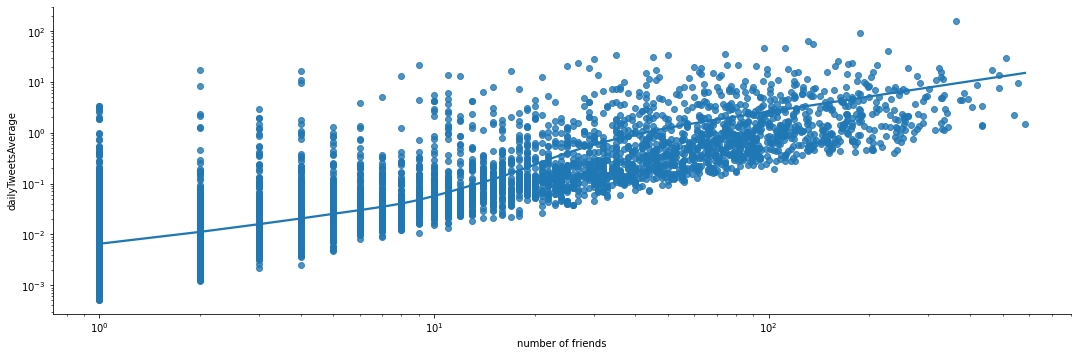

In [134]:
#plot 

splot = sns.lmplot(x="number of friends", y="dailyTweetsAverage", data=a,
           lowess=True,
           aspect=3)

splot.set(xscale = "log")
splot.set(yscale = "log")
# control x and y limits
"""plt.ylim(0.0001, 200)
plt.xlim(1, 100000)"""

 
plt.show()

In [135]:
a[['number of friends','dailyTweetsAverage']].corr( method= 'pearson')

,number of friends,dailyTweetsAverage
number of friends,1.000000,0.351435
dailyTweetsAverage,0.351435,1.000000
